## Evolution du taux effectif en fonction du salaire et du capital

Dernière version du notebook : https://github.com/fmassot/openfisca-web-notebook/

In [2]:
# Libs à importer
%matplotlib inline
import collections
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

ImportError: No module named requests

### Simulation avec OpenFisca

API : http://api.openfisca.fr/api/1/simulate


On calcule avec OpenFisca les revenus et de cotisations pour une personne avec un salaire imposable sur [1000, 100 000] et un capital en action [0, 100 000].

#### Définition des simulations

In [345]:
# SIMULATIONS pour un revenu imposable allant de REVENU_MIN à REVENU_MAX et un capital en action allant de REVENU_MIN à REVENU_MAX
OPENFISCA_API = "http://api.openfisca.fr/api/1/simulate"
CAPITAL_MIN = 0
CAPITAL_MAX = 100000
SALI_MIN = 1000
SALI_MAX = CAPITAL_MAX
COUNT = 200

simulation = dict(
    decomposition = [
        dict(code = 'salsuperbrut', title = 'Salaire super brut'),
        dict(code = 'salnet', title = 'Salaire net'),
        dict(code = 'sali', title = 'Salaire imposable'),
        dict(code = 'revdisp', title = 'Revenu disponible'),
        dict(code = 'cotsoc_noncontrib', title = 'Cotisations sociales non contributives'),
        dict(code = 'cotsal_contrib', title = 'Cotisations sociales salariales contributives'),
        dict(code = 'cotsal_noncontrib', title = 'Cotisations sociales salariales contributives'),
        dict(code='cotpat_main_d_oeuvre', title='cotpat_main_d_oeuvre'),
        dict(code = 'cotpat_contrib', title = 'Cotisations pa contributives'),
        dict(code = 'cotpat_noncontrib', title = 'Cotisations pa non contributives'),
        dict(code = 'irpp', title = 'irpp'),
        dict(code = 'csg', title = 'csg'),
        dict(code = 'crds', title = 'crds'),
        dict(code = 'f2dc', title = 'f2dc'),
        dict(code = 'rev_cap_bar', title = 'rev_cap_bar'),
        ],
    scenarios = [
        dict(
            axes = [
                dict(
                    count = COUNT,
                    max = SALI_MAX,
                    min = SALI_MIN,
                    name = 'sali',
                    ),
                dict(
                    count = COUNT+1,
                    max = CAPITAL_MAX,
                    min = CAPITAL_MIN,
                    name = 'f2dc',
                    )
                ],
            test_case = dict(
                familles = [
                    dict(
                        parents = ['ind0'],
                        ),
                    ],
                foyers_fiscaux = [
                    dict(
                        declarants = ['ind0'],
                        ),
                    ],
                individus = [
                    dict(
                        activite = u'Actif occupé',
                        birth = 1970,
                        cadre = True,
                        id = 'ind0',
                        statmarit = u'Célibataire',
                        ),
                    ],
                menages = [
                    dict(
                        personne_de_reference = 'ind0',
                        ),
                    ],
                ),
            year = 2013,
            ),
        ],
    )

#### Appel de l'API OpenFisca

In [346]:
headers = {'Content-Type': 'application/json','User-Agent': 'OpenFisca-Notebook'}
response = requests.post('http://api.openfisca.fr/api/1/simulate', data=json.dumps(simulation), headers=headers)
variables = response.json(object_pairs_hook = collections.OrderedDict)['value']

#### Calcul du revenu total, du taux effectif, etc.

In [347]:
# Création d'une dataframe pour stocker les résultats et ajouter des variables calculées.
df = pd.DataFrame(dict([(var['code'], var['values']) for var in variables]))
df['revenu_total'] = df['salsuperbrut']+df['f2dc']
df['part_salaire'] = df['salsuperbrut']/df['revenu_total']
df['part_capital'] = df['f2dc']/df['revenu_total']
df['taux_effectif'] = 1 - df['revdisp']/df['revenu_total']
df['taux_sali'] = 1 - df['sali']/df['revenu_total']
df['taux_salnet'] = 1 - df['salnet']/df['revenu_total']
df['taux_noncontrib'] = - (df['csg'] + df['crds'] + df['irpp'] + df['cotpat_noncontrib'] + df['cotsal_noncontrib'])/df['revenu_total']

In [348]:
df[['revenu_total', 'taux_effectif', 'f2dc', 'salsuperbrut']].head(n=20)

,revenu_total,taux_effectif,f2dc,salsuperbrut
0,1385.405151,-3.240972,0,1385.405151
1,2073.951416,-1.981557,0,2073.951416
2,2762.497803,-1.349955,0,2762.497803
3,3452.429443,-0.969774,0,3452.429443
4,4140.976074,-0.716659,0,4140.976074
5,4830.907715,-0.535406,0,4830.907715
6,5519.454102,-0.399693,0,5519.454102
7,6209.385742,-0.293897,0,6209.385742
8,6897.932617,-0.209412,0,6897.932617
9,7587.862793,-0.140137,0,7587.862793


### Evolution du taux effectif en fonction du revenu sans capital

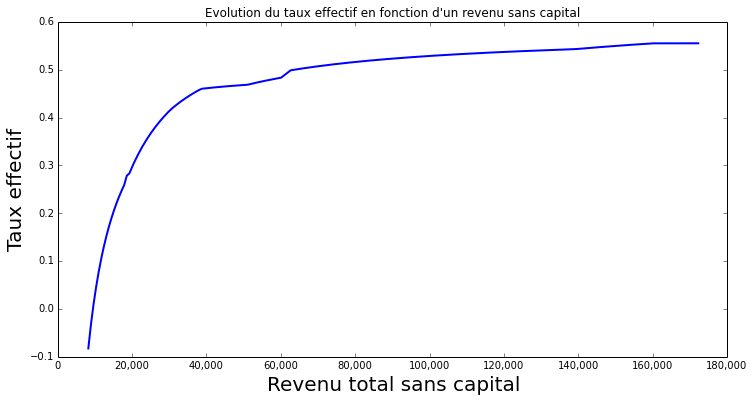

In [349]:
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: "{0:,}".format(int(x)))
ix_without_capital = np.arange(10,COUNT)
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(formatter)
ax.plot(df[['revenu_total']].ix[ix_without_capital], df[['taux_effectif']].ix[ix_without_capital], lw=2)
ax.set_title("Evolution du taux effectif en fonction d'un revenu sans capital")
ax.set_xlabel("Revenu total sans capital", fontsize=20)
ax.set_ylabel("Taux effectif", fontsize=20)

### Calcul du taux effectif fonction du [Revenu total, part capital]

On veut une matrice du taux effectif où chaque ligne définit un revenu total fixe allant de 20 000 € à 200 000 € et chaque colonne définit la composition du revenu total en pourcentage de capital allant de 0% à 90%.


In [350]:
revenu_total = np.arange(20000, CAPITAL_MAX*2, 5000)
base_pct = np.array((np.arange(1, 0.05, -0.05), np.arange(0,0.95,0.05)))
points = np.array([df['salsuperbrut'].tolist(), df['f2dc'].tolist()]).transpose()
points_to_interpolate = np.vstack([base_pct.T * total for total in revenu_total])
interpdata = interpolate.griddata(points, df['taux_effectif'], points_to_interpolate)
results = np.zeros((base_pct.shape[1], base_pct.shape[1]))
for ix in range(base_pct.shape[1]):
    for iy in range(base_pct.shape[1]):
        results[ix,iy] = interpdata[iy + base_pct.shape[1]*ix]

In [351]:
# Evolution de la part du capital dans le revenu total
base_pct[1]

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ])

### Heatmap et contour [revenu total, part capital]

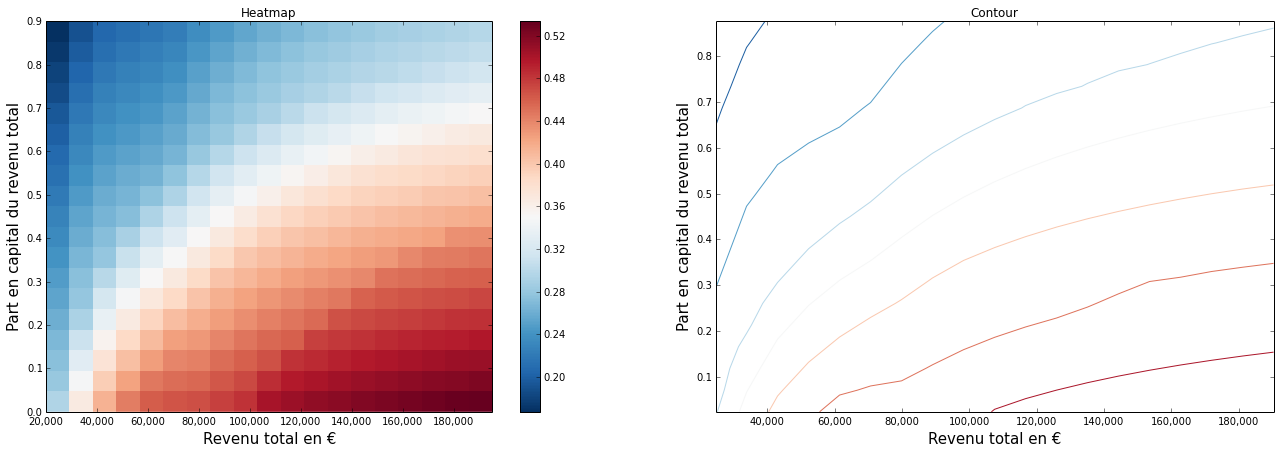

In [352]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,7))
axes[0].set_title('Heatmap')
for ax in axes:
    ax.set_xlabel(u'Revenu total en €', fontsize=15)
    ax.set_ylabel(u'Part en capital du revenu total', fontsize=15)
    ax.xaxis.set_major_formatter(formatter)
im = axes[0].imshow(
        results.T,
        cmap=plt.cm.RdBu_r,
        interpolation='none',
        vmin=results.min(),
        vmax=results.max(),
        origin='lower',
        extent=[revenu_total.min(), revenu_total.max(), base_pct[1].min(), base_pct[1].max()],
        aspect='auto',
    )
cb = fig.colorbar(im, ax=axes[0])

axes[1].set_title('Contour')
cnt = axes[1].contour(
        results.T,
        cmap=plt.cm.RdBu_r,
        vmin=results.min(),
        vmax=results.max(),
        origin='lower',
        extent=[revenu_total.min(), revenu_total.max(), base_pct[1].min(), base_pct[1].max()],
        aspect='auto',
    )